In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
%matplotlib inline

In [86]:
airline = pd.read_csv('data/airline_passengers.csv', index_col="Month", parse_dates=True)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# SMA
## Simple Moving Average

<AxesSubplot:xlabel='Month'>

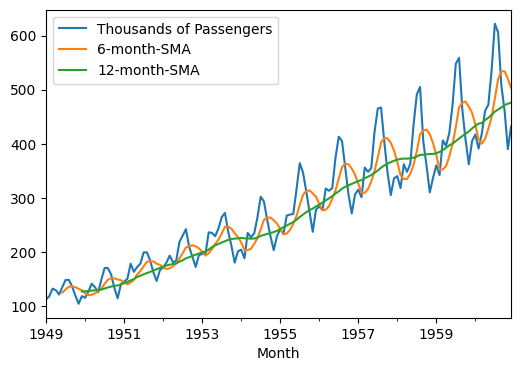

In [3]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.plot(figsize=(6,4))

# EWMA
## Exponentially Weighted Moving Average 

basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.
Exponential functions are used to assign exponentially decreasing weights over time.<br><br>

for exponential smoothing we will have to choose a **smoothing parameter alpha** i.e. the weight for the most recent value (0 to 1) and then it exponentialy decreases the value for other observations using formula-<br><br>
y(t+1) = alpha(y(t)) + alpha(1-alpha)(y(t-1)) + alpha(1-alpha)^2(y(t-2)) and so on..
<br><br>
mostly only last two observations are in effect hence y(t+1) is usually the weighted some of only last two observations
<br><br>
**smoothing level** will always be >0.5 otherwise second last observation will be assigned higher weightage

In [4]:
airline['EWMA-12'] = airline['Thousands of Passengers'].ewm(adjust=False, span=12).mean()

<AxesSubplot:xlabel='Month'>

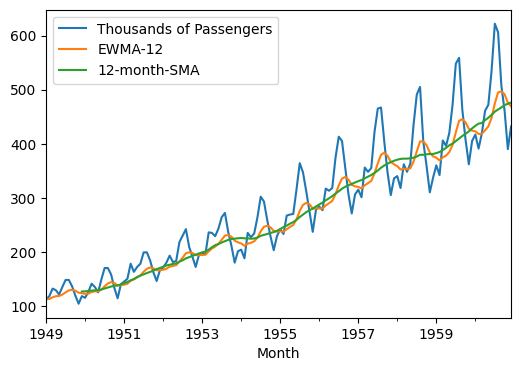

In [46]:
airline[['Thousands of Passengers', 'EWMA-12', '12-month-SMA']].plot(figsize=(6,4))

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ... + (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:
\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}
* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12 months as we have monthly data and repeating on 12 months interval</tt>.

<AxesSubplot:xlabel='Month'>

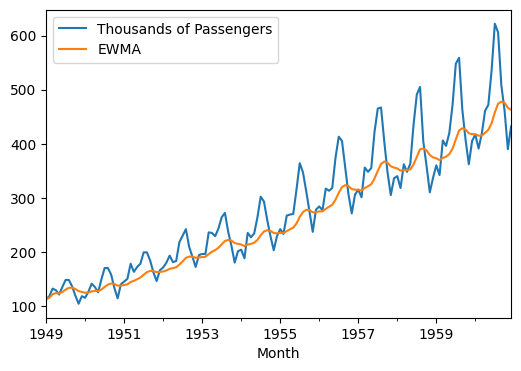

In [48]:
airline['EWMA'] = airline['Thousands of Passengers'].ewm(adjust=True, halflife=6).mean()
airline[['Thousands of Passengers', 'EWMA']].plot(figsize=(6,4))

# Holt-Winters Methods
In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt Linear Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{align}
 l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, && \text{level: weighted average} \\
 b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}), && \text{trend} \\
 y_t &= l_t + b_t, && \text{fitted model} \\
\hat y_{t+h} &= l_t + hb_t, && \text{forecasting model (} h = \text{\# periods into the future)}
\end{align}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{align}
l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, && \text{    level: weighted average}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) && \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) && \text{    seasonal}\\
y_t &= (l_t + b_t) c_t && \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} && \text{    forecasting model (} m = \text{\# periods into the future)}
\end{align}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h3>For Further Reading:</h3>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font color=black>What is Exponential Smoothing?</font></tt></div>

In [87]:
# set frequency of index as month start
airline.index.freq = 'MS'
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## SIMPLE EXPONENTIAL SMOOTHING

In [37]:
span=12
alpha = 2/(1+span)
airline['EWM12'] = airline['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()
airline.head()

,Thousands of Passengers,EWM12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861


In [88]:
model = SimpleExpSmoothing(airline['Thousands of Passengers'])
fitted_model = model.fit(smoothing_level=0.7, optimized=False) # smoothing_level<0.5 corresponds to second last values having higher weight
airline['SES12'] = fitted_model.fittedvalues.shift(-1)
airline.head()

# smoothing_level=0.6

,Thousands of Passengers,SES12
Month,,
1949-01-01,112,112.0000
1949-02-01,118,116.2000
1949-03-01,132,127.2600
1949-04-01,129,128.4780
1949-05-01,121,123.2434


<AxesSubplot:xlabel='Month'>

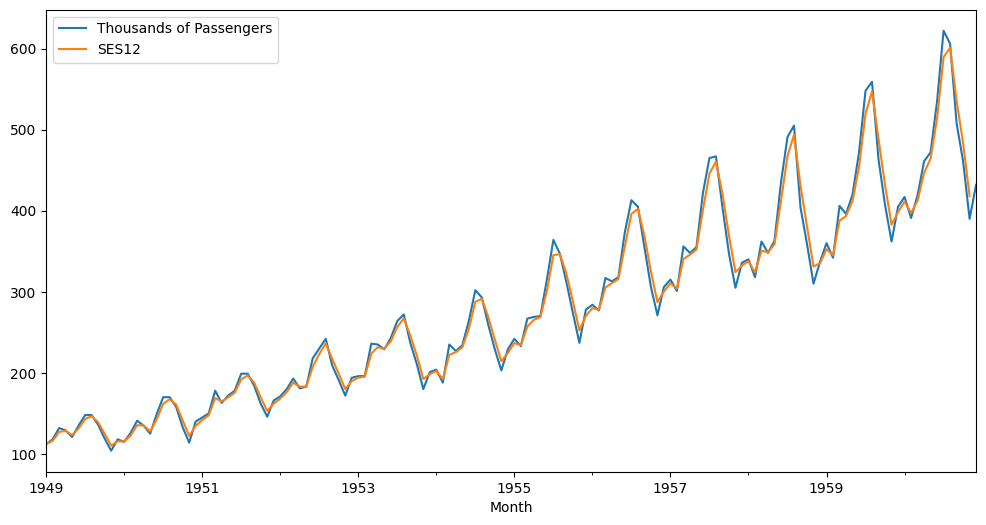

In [89]:
airline[['Thousands of Passengers', 'SES12']].plot(figsize=(12,6))

## DOUBLE EXPONENTIAL SMOOTHING
* multiplicative modeling- it multiplies the weighted average and trend for forecasting, this is used when trend is exponential
* additive modeling- it adds the weighted avearge and trend, this is used when trend is linear

In [90]:
model = ExponentialSmoothing(airline['Thousands of Passengers'], trend='add')
fitted_model = model.fit(smoothing_level=0.7, smoothing_trend=0.1)
airline['DES_add_12'] = fitted_model.fittedvalues.shift(-1)
airline.head()

,Thousands of Passengers,SES12,DES_add_12
Month,,,
1949-01-01,112,112.0000,114.607183
1949-02-01,118,116.2000,119.103567
1949-03-01,132,127.2600,131.155233
1949-04-01,129,128.4780,132.519866
1949-05-01,121,123.2434,126.522866


In [91]:
model = ExponentialSmoothing(airline['Thousands of Passengers'], trend='mul')
fitted_model = model.fit(smoothing_level=0.7, smoothing_trend=0.1)
airline['DES_mul_12'] = fitted_model.fittedvalues.shift(-1)
airline.head()

/opt/conda/envs/st_env1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Thousands of Passengers,SES12,DES_add_12,DES_mul_12
Month,,,,
1949-01-01,112,112.0000,114.607183,113.157419
1949-02-01,118,116.2000,119.103567,117.081558
1949-03-01,132,127.2600,131.155233,129.251776
1949-04-01,129,128.4780,132.519866,130.806012
1949-05-01,121,123.2434,126.522866,124.944337


<AxesSubplot:xlabel='Month'>

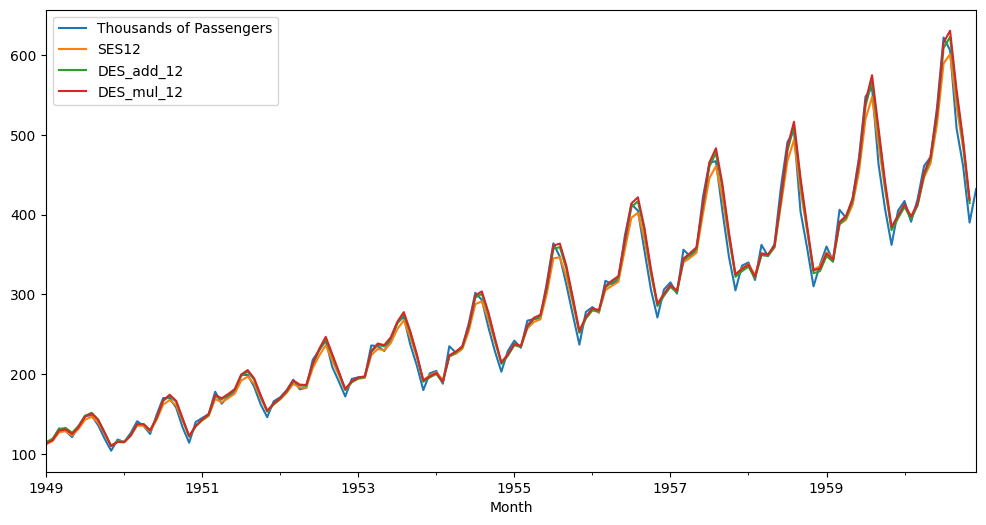

In [92]:
airline[['Thousands of Passengers', 'SES12', 'DES_add_12', 'DES_mul_12']].plot(figsize=(12,6))

<AxesSubplot:xlabel='Month'>

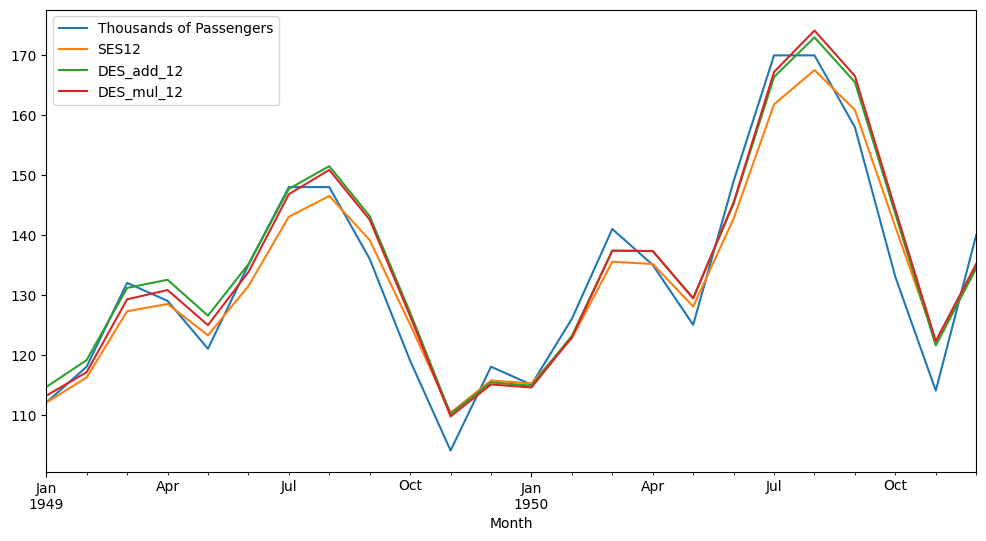

In [93]:
airline[['Thousands of Passengers', 'SES12', 'DES_add_12', 'DES_mul_12']].iloc[:24].plot(figsize=(12,6))

in short multiplicative is following the actual values

## TRIPLE EXPONENTIAL SMOOTHING

In [96]:
model = ExponentialSmoothing(airline['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12)
fitted_model = model.fit(smoothing_level=0.7, smoothing_seasonal=0.7, smoothing_trend=0.1, optimized=False)
airline['TES_mul_12'] = fitted_model.fittedvalues#.shift(-1)
airline.head()
#airline[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[:36].plot(figsize=(12,6))
# smoothing_level=0.6, >> alpha
# smoothing_trend=0.1, >> beta
# smoothing_seasonal=0.28 >> gamma

,Thousands of Passengers,SES12,DES_add_12,DES_mul_12,TES_mul_12
Month,,,,,
1949-01-01,112,112.0000,114.607183,113.157419,114.499871
1949-02-01,118,116.2000,119.103567,117.081558,116.955281
1949-03-01,132,127.2600,131.155233,129.251776,133.866127
1949-04-01,129,128.4780,132.519866,130.806012,125.523151
1949-05-01,121,123.2434,126.522866,124.944337,126.644937


<AxesSubplot:xlabel='Month'>

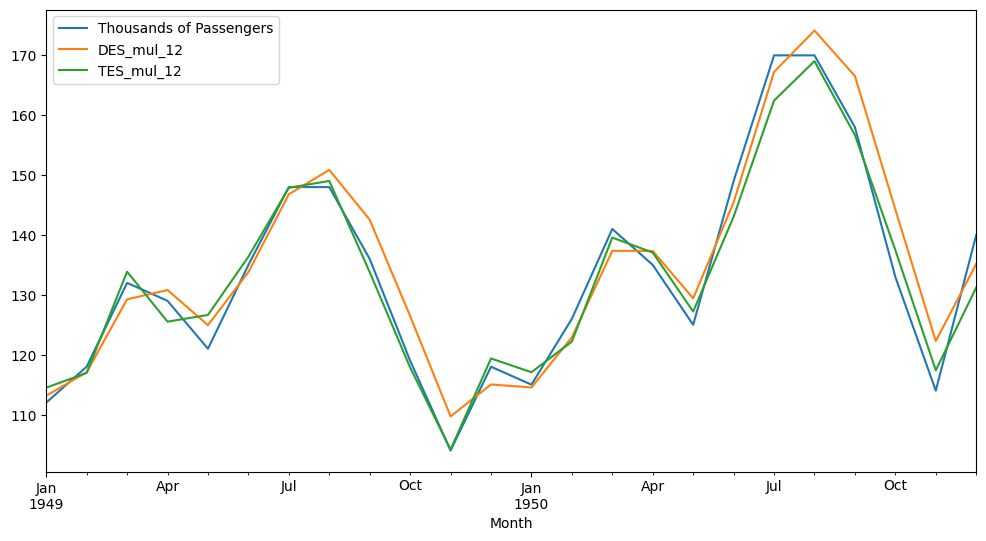

In [97]:
airline[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[:24].plot(figsize=(12,6))